#Required Library

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import RMSprop,Adam
#from keras.datasets import cifar10
%matplotlib inline
import matplotlib.pylab as plt 
from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import activations
from glob import glob
import numpy as np

#Parameters

In [3]:
img_rows = 224
img_cols = 224
channel = 3
classes = 4
depth = 64
dropout = 0.4

#create discriminator

In [255]:
input_shape = (img_rows, img_cols, channel)

discriminator = Sequential()

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(classes + 1))
discriminator.add(Activation('softmax'))

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 112, 256)     19456     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 112, 112, 256)     0         
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 512)       3277312   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 56, 56, 512)       0         
                                                                 
 dropout_6 (Dropout)         (None, 56, 56, 512)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 1024)     

In [260]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])
discriminator_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 5)                 76864005  
                                                                 
Total params: 76,864,005
Trainable params: 0
Non-trainable params: 76,864,005
_________________________________________________________________


In [6]:
dropout = 0.4
depth = 64+64+64+64
dim = 56

#create generator

In [256]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100 + classes))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(3, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 802816)            84295680  
                                                                 
 batch_normalization_3 (Batc  (None, 802816)           3211264   
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 802816)            0         
                                                                 
 reshape_1 (Reshape)         (None, 56, 56, 256)       0         
                                                                 
 dropout_9 (Dropout)         (None, 56, 56, 256)       0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 112, 112, 256)    0         
 2D)                                                  

In [257]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

adversarial_model = Sequential()
adversarial_model.add(generator)
discriminator.trainable = False
adversarial_model.add(discriminator)

adversarial_model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])
adversarial_model.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       88536707  
                                                                 
 sequential_4 (Sequential)   (None, 5)                 76864005  
                                                                 
Total params: 165,400,712
Trainable params: 86,930,691
Non-trainable params: 78,470,021
_________________________________________________________________


In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

#Load images and resize

In [10]:
Healthy = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/h_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  Healthy.append(image)

In [11]:
BrownSpot = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/b_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  BrownSpot.append(image)

In [14]:
Hispa = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/hispa_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  Hispa.append(image)

In [12]:
LeafBlast = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/L_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  LeafBlast.append(image)

In [15]:
Healthy_label = []
for i in range(len(Healthy)):
  Healthy_label.append([0, 0, 0, 1])

BrownSpot_label = []
for i in range(len(BrownSpot)):
  BrownSpot_label.append([0, 0, 1, 0])

Hispa_label = []
for i in range(len(Hispa)):
  Hispa_label.append([0, 1, 0, 0])

LeafBlast_label = []
for i in range(len(LeafBlast)):
  LeafBlast_label.append([1, 0, 0, 0])

#concatenate

In [16]:
x_train = np.concatenate((Healthy, BrownSpot, Hispa, LeafBlast))
y_train = np.concatenate((Healthy_label, BrownSpot_label, Hispa_label, LeafBlast_label))

In [17]:
def normalize(images):
    images=images.astype('float32')
    if images.max() > 1.0:
        images/=255.0
    return images

#OneHotEncoder

In [18]:
def one_hot(labels):
    enc = OneHotEncoder()
    return enc.fit_transform(y_train).toarray()

#normalize

In [19]:
x_train = normalize(x_train)
#y_train = one_hot(y_train)

#create_generator_noise

In [20]:
def create_generator_noise(batch_size):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    sampling = np.random.randint(classes, size=batch_size)
    noise_labels = np.zeros((batch_size, classes))
    noise_labels[np.arange(batch_size), sampling] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input, noise_labels

#create_generator_noise_by_label

In [21]:
def create_generator_noise_by_label(labels):
    noise = np.random.uniform(-1.0, 1.0, size=[len(labels), 100])

    noise_labels = np.zeros((len(labels), classes))
    noise_labels[np.arange(len(labels)), labels] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input

In [22]:
def train(batch_size=64, train_steps=15000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data and the labels
        sample_idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        images_train = x_train[sample_idx, :, :, :]
        labels_train = y_train[sample_idx]
        labels_train = np.concatenate((labels_train, np.zeros(shape=(batch_size, 1))), axis=1)
        
        # Create noise in range -1 to 1 and random labels as input for the generator to generate the fake images
        noise_input, _ = create_generator_noise(batch_size)
        images_fake = generator.predict(noise_input)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        labels_fake = np.zeros(shape=(batch_size, classes+1))
        labels_fake[:,-1] = 1
        
        input_data   = np.concatenate((images_train, images_fake))
        input_labels = np.concatenate((labels_train, labels_fake))

        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate better images
        noise_input, noise_labels = create_generator_noise(batch_size)
        noise_labels = np.concatenate((noise_labels, np.zeros(shape=(batch_size, 1))), axis=1)
        
        adversarial_loss = adversarial_model.train_on_batch(noise_input, noise_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
        
        if i % 100 == 0:
            labels = [1]
            noise = create_generator_noise_by_label(labels)
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

#Train Model

In [23]:
discriminator_losses, adversarial_losses, sample_images  = train(train_steps=15000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/15000 [00:00<?, ?it/s]

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#Fake images generation procedure

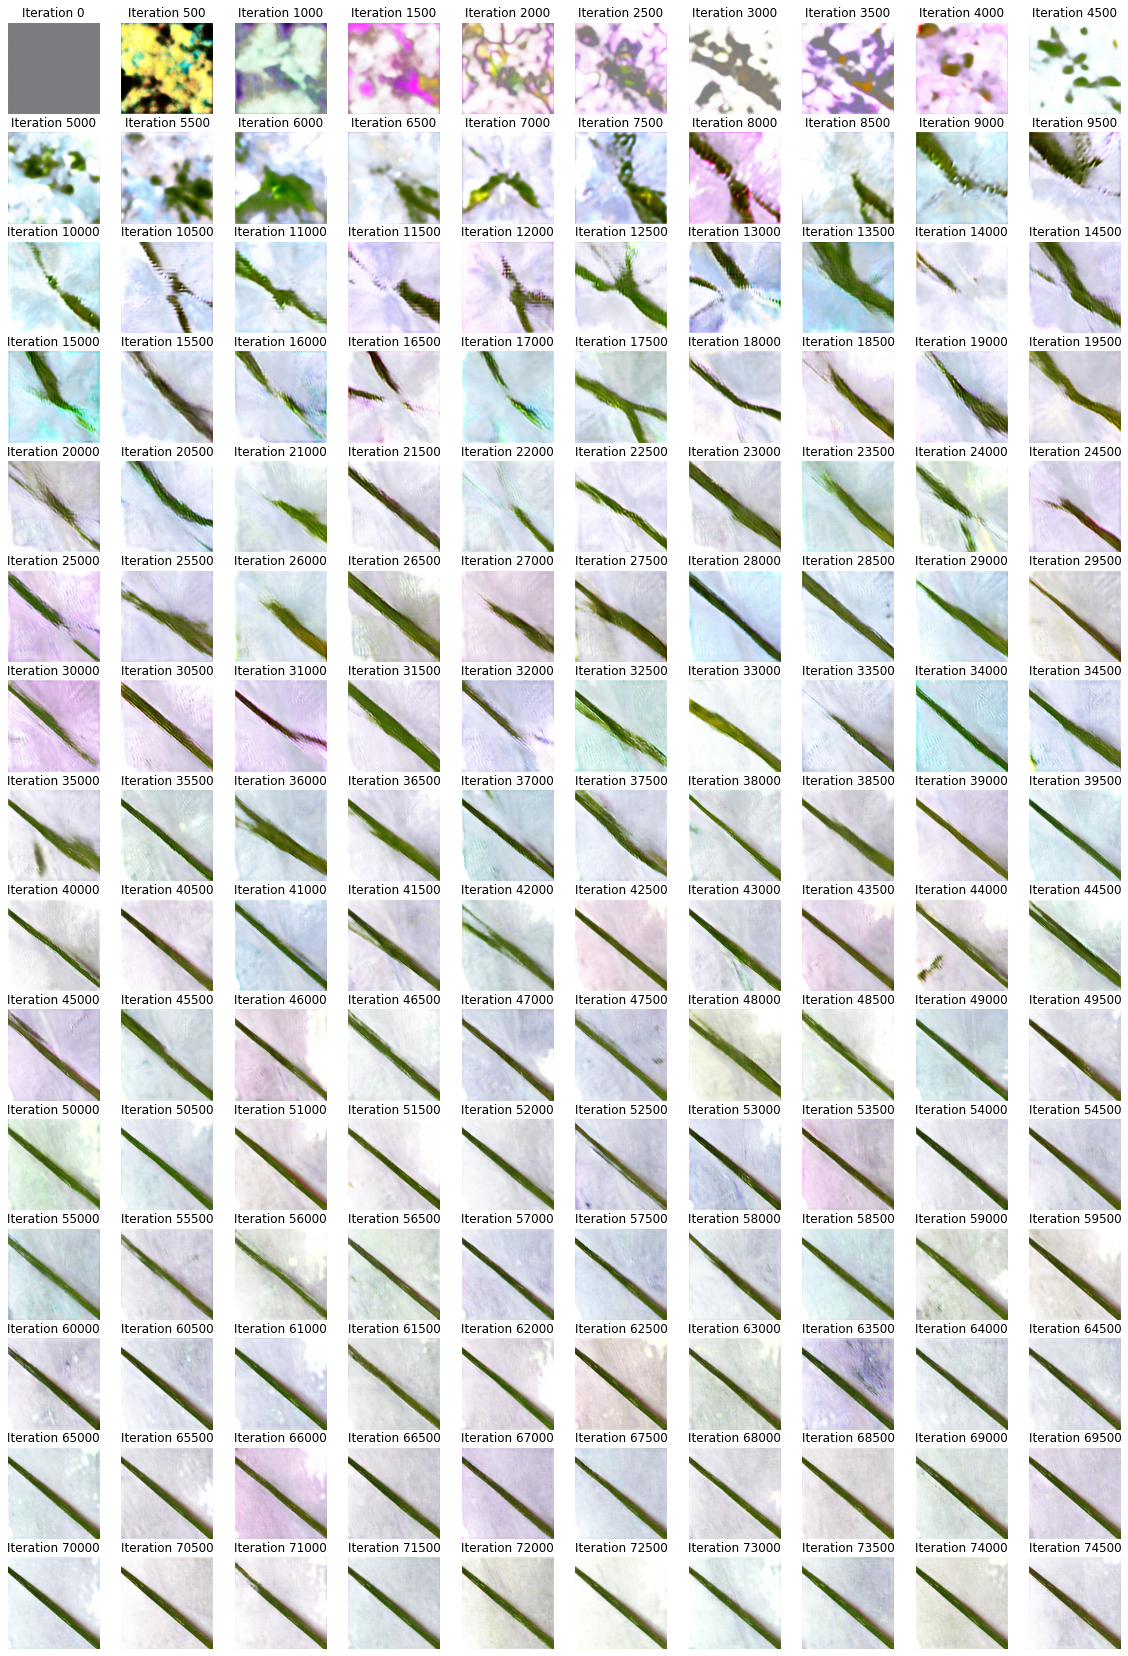

In [25]:
plt.figure(figsize=(20,40))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(20, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)))
    plt.title("Iteration %d" % (i * 500))
    plt.axis('off')

#Accuracy vs loss

Text(0.5, 1.0, 'Adveserial Accuracy')

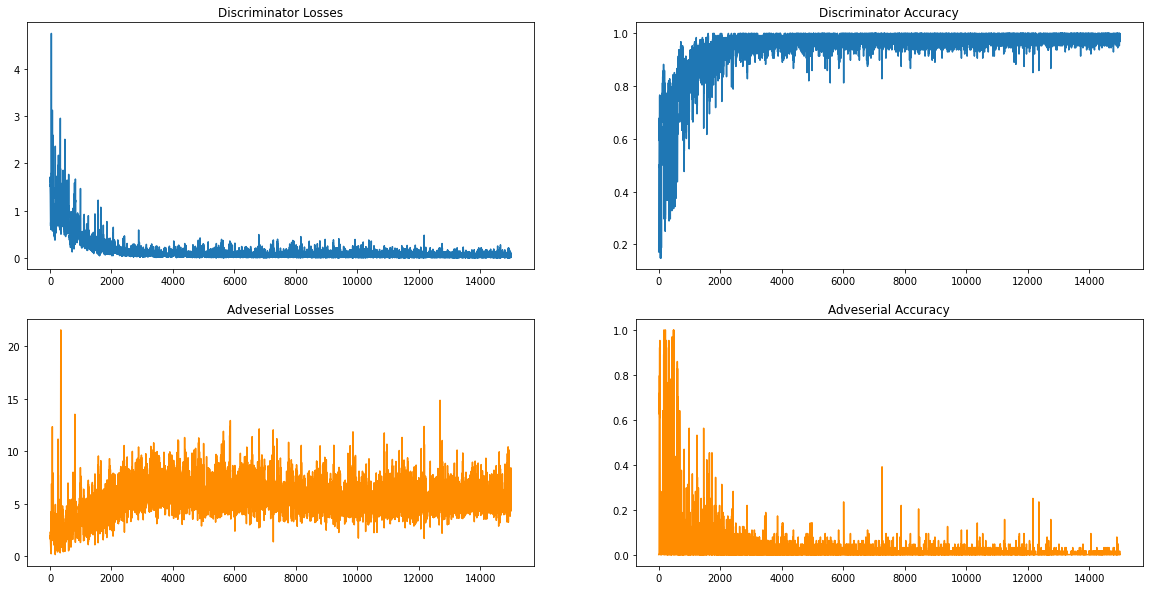

In [26]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Discriminator Accuracy")
###############################################################################
plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Adveserial Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Adveserial Accuracy")

In [27]:
label_names = ["Healthy", "BrownSpot", "Hispa", "LeafBlast"]

#sample_labels

In [28]:
def sample_labels(size):
    labels = []
    for label, _ in enumerate(label_names):
        for sample_size in range(size):
            labels.append(label)
    return labels

In [151]:
from matplotlib import pyplot as plt
import cv2
from PIL import Image

#Generate Fake Images

In [252]:
labels = sample_labels(20)
noise = create_generator_noise_by_label(labels)
fake_images = generator.predict(noise)

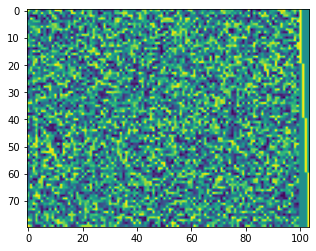

In [253]:
plt.imshow(noise)

#Generate images from array and save it in a particular folder

In [242]:
j=0
###############################################################################################################################################
for i in range(len(fake_images)):
  if i<49:
    j+=1
    plt.imsave(arr=fake_images[j], fname='/content/drive/MyDrive/#Rice_dataset#/Fake_Images/LeafBlast/LeafBlast10/' + str(j) + '_gen.jpg')

################################################################################################################################################

  elif 49<i<49+50:
    j+=1
    plt.imsave(arr=fake_images[j], fname='/content/drive/MyDrive/#Rice_dataset#/Fake_Images/Hispa/Hispa10/' + str(j) + '_gen.jpg')

################################################################################################################################################

  elif 49+50<i<49+50+50:
    j+=1
    plt.imsave(arr=fake_images[j], fname='/content/drive/MyDrive/#Rice_dataset#/Fake_Images/BrownSpot/BrownSpot10/' + str(j) + '_gen.jpg')

#################################################################################################################################################
  elif 49+50+50<i<49+50+50+50:
    j+=1
    plt.imsave(arr=fake_images[j], fname='/content/drive/MyDrive/#Rice_dataset#/Fake_Images/healthy/healthy10/' + str(j) + '_gen.jpg')

In [89]:
label_names = ["LeafBlast", "Hispa", "BrownSpot", "Healthy"]

#Output_Images#

In [ ]:
fig, big_axes = plt.subplots(figsize=(20, 20) , nrows=len(label_names), ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(label_names[row-1], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

labels = sample_labels(3)
noise = create_generator_noise_by_label(labels)

fake_images = generator.predict(noise)

plt.figure(figsize=(40,40))
for i, fake_image in enumerate(fake_images, 1):
    ax = fig.add_subplot(len(label_names), 3, i)
    ax.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    ax.axis('off')